In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import Normal, kl_divergence

In [2]:
def generate_data(n=300):
    X = np.linspace(-4, 4, n)
    y = np.sin(X) + 0.3 * X + np.random.normal(0, 0.3 + 0.5 * np.abs(X), size=n)
    return X.reshape(-1, 1), y

X, y = generate_data()
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [3]:
class QuantileRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
def quantile_loss(y_pred, y_true, quantile):
    errors = y_true - y_pred
    return torch.max((quantile - 1) * errors, quantile * errors).mean()

In [5]:
def train_quantile_model(quantile, epochs=300):
    model = QuantileRegressor()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = quantile_loss(y_pred, y_train, quantile)
        loss.backward()
        optimizer.step()
    
    return model

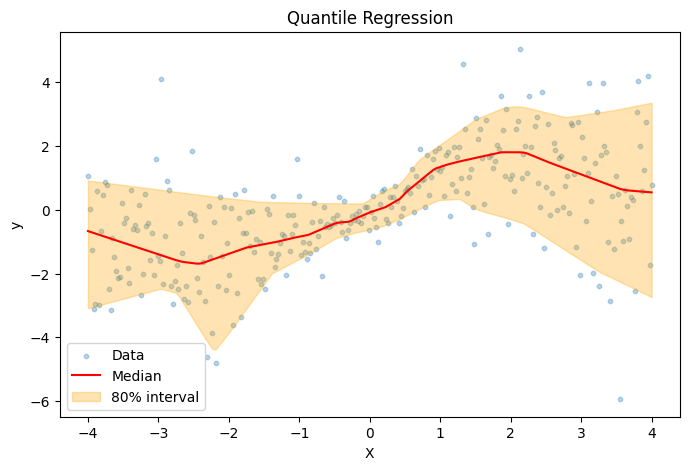

In [7]:
# ==== Train for multiple quantiles ====
X_test = torch.linspace(-4, 4, 200).view(-1, 1)
quantiles = [0.1, 0.5, 0.9]
models = {q: train_quantile_model(q) for q in quantiles}

predictions = {q: models[q](X_test).detach().numpy().squeeze() for q in quantiles}

# ==== Plot Results ====
plt.figure(figsize=(8, 5))
plt.scatter(X, y, s=10, alpha=0.3, label="Data")
plt.plot(X_test, predictions[0.5], label="Median", color="red")
plt.fill_between(X_test.squeeze(), predictions[0.1], predictions[0.9], alpha=0.3, label="80% interval", color="orange")
plt.legend()
plt.title("Quantile Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [9]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_std=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Learnable posterior parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-3))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features).fill_(-3))

        # Prior: fixed normal distribution
        self.prior = Normal(0, prior_std)

    def forward(self, x):
        # Compute posterior std
        weight_std = torch.exp(self.weight_log_sigma)
        bias_std = torch.exp(self.bias_log_sigma)

        # Sample from posterior
        weight_eps = torch.randn_like(self.weight_mu)
        bias_eps = torch.randn_like(self.bias_mu)

        weight = self.weight_mu + weight_std * weight_eps
        bias = self.bias_mu + bias_std * bias_eps

        return F.linear(x, weight, bias)

    def kl_loss(self):
        # KL divergence between posterior q(w|θ) and prior p(w)
        q_w = Normal(self.weight_mu, torch.exp(self.weight_log_sigma))
        q_b = Normal(self.bias_mu, torch.exp(self.bias_log_sigma))
        kl = kl_divergence(q_w, self.prior).sum() + kl_divergence(q_b, self.prior).sum()
        return kl

In [10]:
class BayesianRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            BayesianLinear(1, 64),
            nn.ReLU(),
            BayesianLinear(64, 64),
            nn.ReLU(),
            BayesianLinear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

    def kl_loss(self):
        # Sum KL losses from all BayesianLinear layers
        kl = 0.0
        for layer in self.model:
            if isinstance(layer, BayesianLinear):
                kl += layer.kl_loss()
        return kl

In [11]:
def train_model(model, X_train, y_train, epochs=2000, lr=1e-3, kl_scale=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        y_pred = model(X_train)
        mse = mse_loss(y_pred, y_train)
        kl = model.kl_loss() * kl_scale
        loss = mse + kl

        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch} | MSE: {mse.item():.4f} | KL: {kl.item():.4f} | Total: {loss.item():.4f}")

In [12]:
def predict_mc(model, X_test, n_samples=100):
    model.eval()
    preds = []
    for _ in range(n_samples):
        with torch.no_grad():
            preds.append(model(X_test).numpy().squeeze())
    preds = np.array(preds)
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)
    return mean, std

Epoch 0 | MSE: 2.8394 | KL: 109.0947 | Total: 111.9341
Epoch 200 | MSE: 2.0140 | KL: 100.3604 | Total: 102.3744
Epoch 400 | MSE: 2.0371 | KL: 91.7157 | Total: 93.7528
Epoch 600 | MSE: 1.8872 | KL: 83.1529 | Total: 85.0401
Epoch 800 | MSE: 2.1486 | KL: 74.6894 | Total: 76.8379
Epoch 1000 | MSE: 1.9927 | KL: 66.3628 | Total: 68.3555
Epoch 1200 | MSE: 2.0714 | KL: 58.2210 | Total: 60.2924
Epoch 1400 | MSE: 1.9378 | KL: 50.3824 | Total: 52.3203
Epoch 1600 | MSE: 1.9231 | KL: 42.9657 | Total: 44.8888
Epoch 1800 | MSE: 2.2309 | KL: 36.1942 | Total: 38.4251


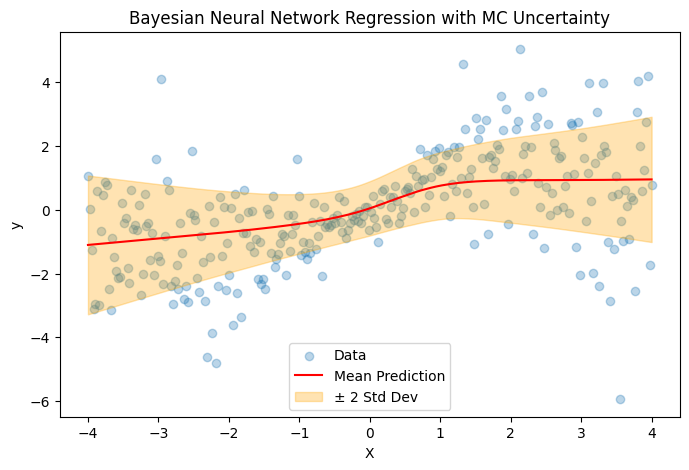

In [13]:
model = BayesianRegressor()
train_model(model, X_train, y_train, epochs=2000, lr=1e-3, kl_scale=0.01)

X_test = torch.linspace(-4, 4, 200).view(-1, 1)
mean, std = predict_mc(model, X_test, n_samples=200)

# ==========================
# 7. Plot Results
# ==========================
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.3, label="Data")
plt.plot(X_test.numpy(), mean, color="red", label="Mean Prediction")
plt.fill_between(X_test.squeeze().numpy(), mean - 2 * std, mean + 2 * std,
                 alpha=0.3, color="orange", label="± 2 Std Dev")
plt.legend()
plt.title("Bayesian Neural Network Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [21]:
class DropoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x, training=False):
        x = F.relu(F.dropout(self.fc1(x), p=0.1, training=training))
        x = F.relu(F.dropout(self.fc2(x), p=0.1, training=training))
        return self.fc3(x)


In [22]:
def train_mc_dropout(X_train, y_train):
    model = DropoutNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)

    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        out = model(X_train_tensor)
        loss = loss_fn(out, y_train_tensor)
        loss.backward()
        optimizer.step()

    return model

In [23]:
def predict_mc_dropout(model, X_test, n_samples=100):
    preds = []
    X_test_tensor = torch.FloatTensor(X_test)

    for _ in range(n_samples):
        with torch.no_grad():
            # Force dropout layers to be active by passing training=True
            pred = model(X_test_tensor, training=True).numpy().squeeze()
            preds.append(pred)
    
    preds = np.array(preds)
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)
    return mean, std

In [24]:
mc_model = train_mc_dropout(X_train, y_train)

In [25]:
X_grid = np.linspace(-4, 4, 200).reshape(-1, 1)
mc_mean, mc_std = predict_mc_dropout(mc_model, X_grid)

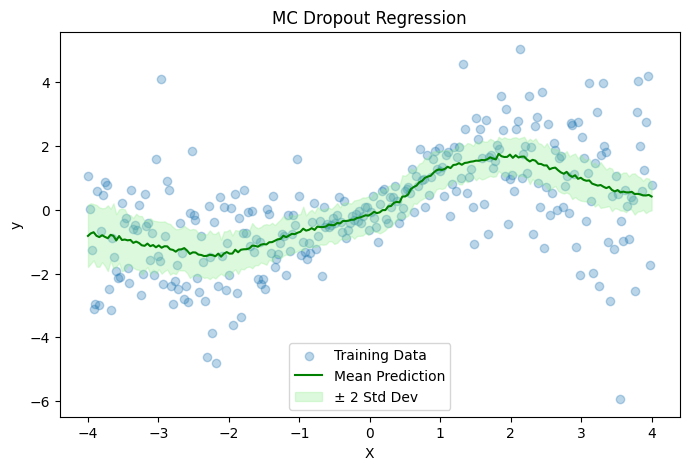

In [26]:
plt.figure(figsize=(8, 5))

# Plot original training data
plt.scatter(X, y, alpha=0.3, label="Training Data")

# Mean prediction from MC Dropout
plt.plot(X_grid, mc_mean, color="green", label="Mean Prediction")

# Uncertainty band (±2 std)
plt.fill_between(
    X_grid.squeeze(),
    mc_mean - 2 * mc_std,
    mc_mean + 2 * mc_std,
    alpha=0.3,
    color="lightgreen",
    label="± 2 Std Dev"
)

plt.title("MC Dropout Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

In [27]:
def train_ensemble(X_train, y_train, n_models=5):
    ensemble = []
    for i in range(n_models):
        torch.manual_seed(i)
        model = DropoutNet()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()

        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)

        for epoch in range(300):
            model.train()
            optimizer.zero_grad()
            out = model(X_train_tensor)
            loss = loss_fn(out, y_train_tensor)
            loss.backward()
            optimizer.step()

        ensemble.append(model)
    return ensemble

def predict_ensemble(models, X_test):
    X_test_tensor = torch.FloatTensor(X_test)
    preds = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X_test_tensor).numpy().squeeze()
            preds.append(pred)
    preds = np.array(preds)
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)
    return mean, std

In [28]:
ens_models = train_ensemble(X_train, y_train)


In [29]:
ens_mean, ens_std = predict_ensemble(ens_models, X_grid)

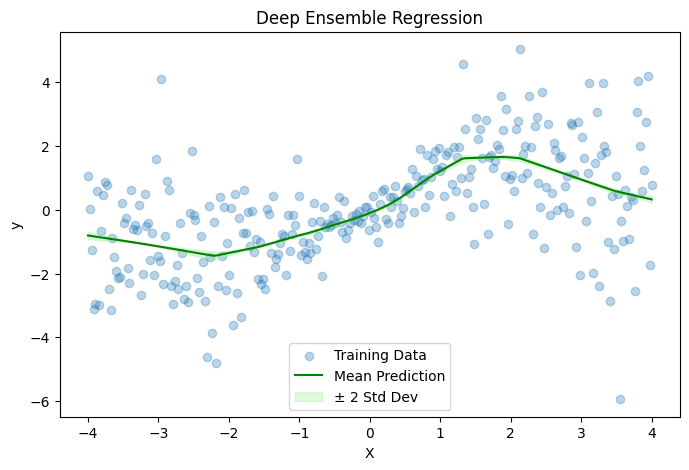

In [32]:
plt.figure(figsize=(8, 5))

# Plot original training data
plt.scatter(X, y, alpha=0.3, label="Training Data")

# Mean prediction from MC Dropout
plt.plot(X_grid, ens_mean, color="green", label="Mean Prediction")

# Uncertainty band (±2 std)
plt.fill_between(
    X_grid.squeeze(),
    ens_mean - 2 * ens_std,
    ens_mean + 2 * ens_std,
    alpha=0.3,
    color="lightgreen",
    label="± 2 Std Dev"
)

plt.title("Deep Ensemble Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()